In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim


## DATA EXPLORATION
Read data and display some examples.

In [2]:
train_df_org = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df_org = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
train_df = train_df_org.copy()
test_df = test_df_org.copy()

In [4]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [5]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
# Checking null counts to later fill or discard according to the dtypes and distributions 
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
# Checking dtypes to adjust data by their dtypes (numeric or not)
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
num_columns = [col for col, dtype in train_df.dtypes.items() if dtype == 'float64']
str_columns = [col for col, dtype in train_df.dtypes.items() if dtype == 'object']

print(num_columns) 
print(str_columns)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


## DATA PREPROCESSING

In [9]:
# Remove columns that don't affect the decision.
def remove_unneccessary_cols(df, col_names_to_remove):
    for col in col_names_to_remove:
        if col in df.columns:
            df.drop(col_names_to_remove, axis=1, inplace=True)
    print("Columns removed:", col_names_to_remove)
    return df

In [10]:
cols = ['Name', 'PassengerId']
train_df = remove_unneccessary_cols(train_df, cols)
train_df.columns

Columns removed: ['Name', 'PassengerId']


Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

### Numeric Columns Preprocessing

In [11]:
train_df[train_df['Age'].notna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


min:0.0 | max: 79.0 | skew: 0.41909658301471536 | mean: 28.82793046746535


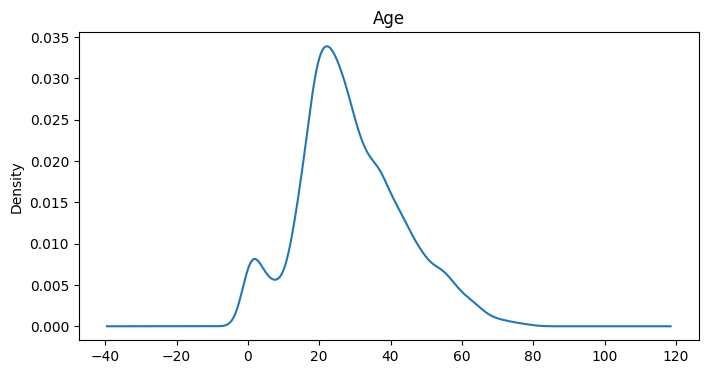

min:0.0 | max: 14327.0 | skew: 6.333014062092135 | mean: 224.687617481203


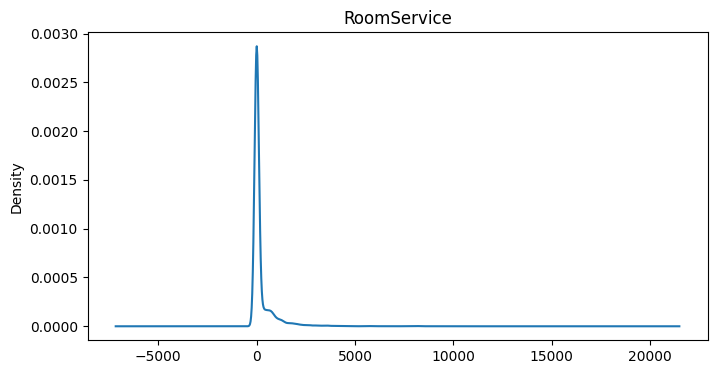

min:0.0 | max: 29813.0 | skew: 7.102227852514122 | mean: 458.07720329024676


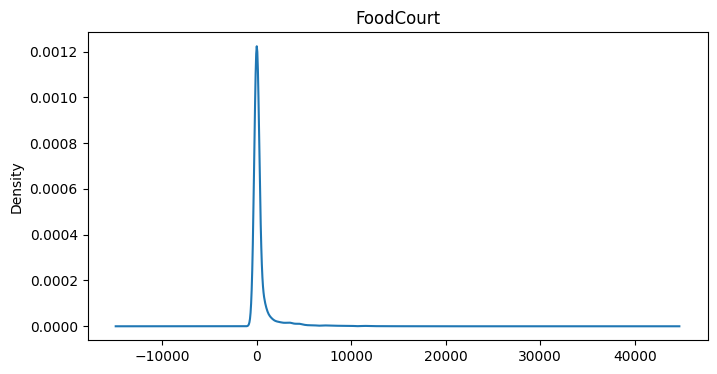

min:0.0 | max: 23492.0 | skew: 12.62756203889759 | mean: 173.72916912197996


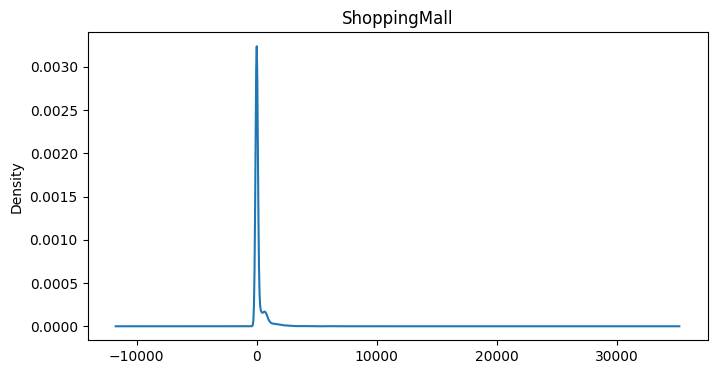

min:0.0 | max: 22408.0 | skew: 7.63601988471242 | mean: 311.1387779083431


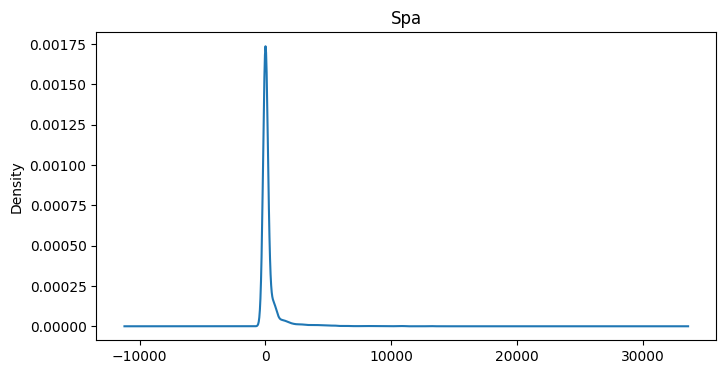

min:0.0 | max: 24133.0 | skew: 7.819731592048683 | mean: 304.8547912992357


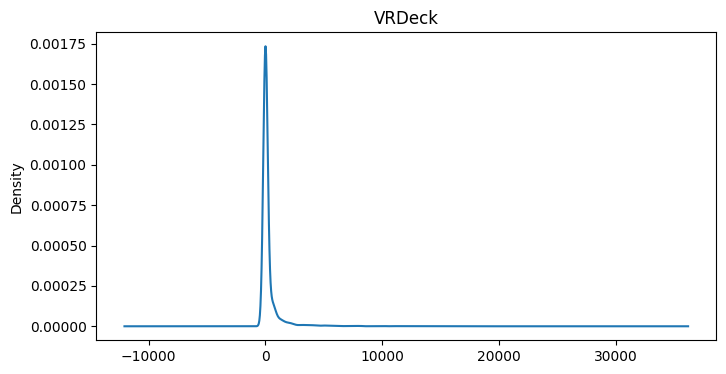

In [12]:
# Checkinge distributions of the numeric columns.
for col in num_columns:
#     train_df2 = train_df.copy()
#     null_df = train_df2[train_df2[col].isna()]
    column = train_df[col]
    
    min_val = column.min()
    max_val = column.max()
    skew = column.skew()
    
#     train_df2 = train_df2[train_df2[col].notna()]
    
    
#     divider = max_val - min_val
#     train_df2[col] = 1 + (train_df2[col] - min_val) / (divider) 
#     train_df2[col] = np.log(train_df2[col])
    
#     train_df2 = pd.concat([train_df2, null_df])
    
    plt.figure(figsize=(8, 4))
    plt.title(col)
    plt.ylabel('Count')
    
    print(f"min:{column.min()} | max: {column.max()} | skew: {column.skew()} | mean: {column.mean()}")
    
    train_df[col].plot(kind='kde')

    plt.show()
#     train_df = train_df2


In [13]:
# Make the age column categorical.
def make_age_categorical(df):
    
    age_bins = [-1, 18, 30, 45, 60, 100]
    age_labels = ['Child', 'Teen', 'Adult', 'Senior', 'Old']
    df['AgeGroup'] = pd.cut(df.loc[~df['Age'].isna(), 'Age'], bins=age_bins, labels=age_labels)
    # drop the original age column because it is unnecessary anymore
    df.drop('Age', axis=1, inplace=True)
    
    return df


num_columns.remove('Age')
train_df = make_age_categorical(train_df)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,Adult
1,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,Teen
2,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,Senior
3,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,Adult
4,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,Child


### Anomaly Detection using IQR



When I apply anomaly detection null values are vanishing for a column. So first, I keep the null values in a different variable, then merge it after removing the anomalies. After anomalies are removed, null values can be imputed more accuractely.

In [14]:
def remove_anomalies(df, column_names, multiplier=1.5):
    
    for col in column_names:
        
        null_df = df[df[col].isna()]
        
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)

        IQR = Q3 - Q1

        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        df = pd.concat([df, null_df])
        
    return df

In [15]:
train_df.shape

(8693, 12)

In [16]:
print(len(train_df)) # check len before removing anomalies to see how many data is removed.
train_df = remove_anomalies(train_df, num_columns)
train_df.head(), len(train_df)

8693


(  HomePlanet CryoSleep  Cabin  Destination    VIP  RoomService  FoodCourt  \
 0     Europa     False  B/0/P  TRAPPIST-1e  False          0.0        0.0   
 1      Earth     False  F/0/S  TRAPPIST-1e  False        109.0        9.0   
 2     Europa     False  A/0/S  TRAPPIST-1e   True         43.0     3576.0   
 3     Europa     False  A/0/S  TRAPPIST-1e  False          0.0     1283.0   
 4      Earth     False  F/1/S  TRAPPIST-1e  False        303.0       70.0   
 
    ShoppingMall     Spa  VRDeck  Transported AgeGroup  
 0           0.0     0.0     0.0        False    Adult  
 1          25.0   549.0    44.0         True     Teen  
 2           0.0  6715.0    49.0        False   Senior  
 3         371.0  3329.0   193.0        False    Adult  
 4         151.0   565.0     2.0         True    Child  ,
 8649)

### Standardizing numerical columns

In [17]:
def standardize_num_columns(df, columns):
    
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    
    return df

In [18]:
num_columns

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [19]:
train_df = standardize_num_columns(train_df, num_columns)

In [20]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,False,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,False,Adult
1,Earth,False,F/0/S,TRAPPIST-1e,False,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,True,Teen
2,Europa,False,A/0/S,TRAPPIST-1e,True,-0.288114,2.150043,-0.352491,6.527927,-0.232789,False,Senior
3,Europa,False,A/0/S,TRAPPIST-1e,False,-0.359961,0.580400,0.469440,3.088351,-0.093104,False,Adult
4,Earth,False,F/1/S,TRAPPIST-1e,False,0.146315,-0.249943,-0.017958,0.280616,-0.278380,True,Child


### Imputing null values for numeric columns

In [21]:
def impute_numeric_cols(df, columns):
    
    for column in columns:
        col = df[column]
        col.fillna(col.median(), inplace=True)

    return df

In [22]:
train_df = impute_numeric_cols(train_df, num_columns)

In [23]:
train_df.isna().sum()

HomePlanet      200
CryoSleep       216
Cabin           197
Destination     181
VIP             202
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
AgeGroup        179
dtype: int64

## Categorical Columns Preprocessing

In [24]:
str_columns.append('AgeGroup')
str_columns.remove('PassengerId')
str_columns.remove('Name')

str_columns

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'AgeGroup']

In [25]:
train_df[str_columns].nunique()

HomePlanet        3
CryoSleep         2
Cabin          6540
Destination       3
VIP               2
AgeGroup          5
dtype: int64

### VIP and CyroSleep columns are mapped to 0 and 1

In [26]:
# VIP and CyroSleep columns are true or false values. So we can convert them as 0 and 1 using mapping easily.

def map_vip_and_cryosleep(df):
    
    mapping = {False: 0., True:1.}
    df['VIP'] = df['VIP'].map(mapping)
    df['CryoSleep'] = df['CryoSleep'].map(mapping)
    
    return df

In [27]:
train_df = map_vip_and_cryosleep(train_df)

In [28]:
print(train_df['VIP'].value_counts())
print(train_df['CryoSleep'].value_counts())

VIP
0.0    8253
1.0     194
Name: count, dtype: int64
CryoSleep
0.0    5396
1.0    3037
Name: count, dtype: int64


### Cabin Column

In [29]:
# cabin column is splitted 3 by `/` as deck, num and side as indicated in Data part of the Competition

def split_cabin(df):
    
    df[['deck','num', 'side']] = df['Cabin'].str.split('/',expand=True)
    df['num'] = df['num'].astype(float)
    df.drop('Cabin', axis=1, inplace=True)
    return df

In [30]:
train_df = split_cabin(train_df)

In [31]:
train_df[['deck', 'num', 'side']].nunique() # checking unique values for deck, num  and side

deck       8
num     1816
side       2
dtype: int64

### One-Hot Encoding

In [32]:
def one_hot_encode_columns(df, columns):
    
    for column in columns:
        
        df_encoded = pd.get_dummies(df[column], prefix=column)
        df.drop(columns=[column], inplace=True)
        df = pd.concat([df, df_encoded], axis=1)

    return df

In [33]:
train_df = one_hot_encode_columns(train_df, ['HomePlanet', 'Destination', 'AgeGroup', 'deck'])
train_df.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,num,side,...,AgeGroup_Senior,AgeGroup_Old,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,0.0,0.0,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,False,0.0,P,...,False,False,False,True,False,False,False,False,False,False
1,0.0,0.0,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,True,0.0,S,...,False,False,False,False,False,False,False,True,False,False
2,0.0,1.0,-0.288114,2.150043,-0.352491,6.527927,-0.232789,False,0.0,S,...,True,False,True,False,False,False,False,False,False,False
3,0.0,0.0,-0.359961,0.580400,0.469440,3.088351,-0.093104,False,0.0,S,...,False,False,True,False,False,False,False,False,False,False
4,0.0,0.0,0.146315,-0.249943,-0.017958,0.280616,-0.278380,True,1.0,S,...,False,False,False,False,False,False,False,True,False,False


### Encoding `deck`, `num` and `side`

In [34]:
def map_side_column(df):
    
    side_mapping = {'P':0., 'S':1.}
    df['side'] = df['side'].map(side_mapping)    
    return df

In [35]:
train_df = map_side_column(train_df)

Num variable goes from 0 to 1800. It determines the passenger's region of the ship in a roughly and in my opinion.
So I decide to group the column.

In [36]:
def categorize_num_column(df):

    bins = [0, 600, 1200, 1801]
    labels = [0, 1, 2]

    df['num_label'] = pd.cut(df['num'], bins=bins, labels=labels, include_lowest=True)
    df.drop('num', axis=1, inplace=True)
    
    return df

In [37]:
train_df = categorize_num_column(train_df)

In [38]:
train_df.replace({True:1., False:0.}, inplace=True)

In [39]:
train_df.dtypes

CryoSleep                     float64
VIP                           float64
RoomService                   float64
FoodCourt                     float64
ShoppingMall                  float64
Spa                           float64
VRDeck                        float64
Transported                   float64
side                          float64
HomePlanet_Earth              float64
HomePlanet_Europa             float64
HomePlanet_Mars               float64
Destination_55 Cancri e       float64
Destination_PSO J318.5-22     float64
Destination_TRAPPIST-1e       float64
AgeGroup_Child                float64
AgeGroup_Teen                 float64
AgeGroup_Adult                float64
AgeGroup_Senior               float64
AgeGroup_Old                  float64
deck_A                        float64
deck_B                        float64
deck_C                        float64
deck_D                        float64
deck_E                        float64
deck_F                        float64
deck_G      

In [40]:
train_df['Transported'] = train_df['Transported'].astype(int)
train_df.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,side,HomePlanet_Earth,...,AgeGroup_Old,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,num_label
0,0.0,0.0,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,1.0,-0.288114,2.150043,-0.352491,6.527927,-0.232789,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,-0.359961,0.580400,0.469440,3.088351,-0.093104,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.146315,-0.249943,-0.017958,0.280616,-0.278380,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [41]:
train_df['CryoSleep'].value_counts()

CryoSleep
0.0    5396
1.0    3037
Name: count, dtype: int64

### VIP
Most of the passengers are not VIP likely. So filling with 0s seems okey to me.

In [42]:
train_df['VIP'].fillna(0, inplace=True)

### Rest of the categorical columns are filled with most frequent.

In [43]:
def fill_most_freq(df, cols):
    
    for col in df.columns:
        
        val = df[col].mode()[0]
        df[col].fillna(val, inplace=True)
        
    return df

In [44]:
columns_with_nan = ['CryoSleep', 'side', 'num_label']
train_df = fill_most_freq(train_df, columns_with_nan)

In [45]:
train_df.dropna()
train_df.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,side,HomePlanet_Earth,...,AgeGroup_Old,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,num_label
0,0.0,0.0,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,1.0,-0.288114,2.150043,-0.352491,6.527927,-0.232789,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,-0.359961,0.580400,0.469440,3.088351,-0.093104,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.146315,-0.249943,-0.017958,0.280616,-0.278380,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


## TRAINING

In [46]:
train_df['num_label'] = train_df['num_label'].astype(float)
X = train_df.drop('Transported', axis=1)
y = train_df['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(SimpleBinaryClassifier, self).__init__()
        self.input_size = input_size

        # Define the layers
        self.hidden_layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),  # BatchNorm layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)
        )
        
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        x = self.sigmoid(self.hidden_layers(x))  # Apply sigmoid activation for binary classification
        return x

In [48]:
model = SimpleBinaryClassifier(X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust optimizer and learning rate
num_epochs = 2000

In [49]:
loss_train_values = []  
loss_val_values = []  
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    optimizer.zero_grad()  # Zero the gradient buffers

    # Forward pass
    outputs = model(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1))

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()  # Set the model in evaluation mode
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))

            # Clamp the validation output to be between 0 and 1
            val_outputs = torch.clamp(val_outputs, 0, 1)

            val_loss = criterion(val_outputs, torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss_train: {loss.item()}, Loss_val: {val_loss.item()}')

        loss_train_values.append(loss.item())
        loss_val_values.append(val_loss.item())
        


Epoch [1/2000], Loss_train: 0.7341819405555725, Loss_val: 0.6999276280403137
Epoch [11/2000], Loss_train: 0.7186081409454346, Loss_val: 0.6968157291412354
Epoch [21/2000], Loss_train: 0.7069266438484192, Loss_val: 0.6907126307487488
Epoch [31/2000], Loss_train: 0.7026070952415466, Loss_val: 0.6813900470733643
Epoch [41/2000], Loss_train: 0.6910011172294617, Loss_val: 0.6723548769950867
Epoch [51/2000], Loss_train: 0.6842378377914429, Loss_val: 0.6638087630271912
Epoch [61/2000], Loss_train: 0.6827399134635925, Loss_val: 0.6555815935134888
Epoch [71/2000], Loss_train: 0.6718690991401672, Loss_val: 0.6476458311080933
Epoch [81/2000], Loss_train: 0.6575092077255249, Loss_val: 0.6383565664291382
Epoch [91/2000], Loss_train: 0.6524530649185181, Loss_val: 0.6300560832023621
Epoch [101/2000], Loss_train: 0.6449571251869202, Loss_val: 0.6213648915290833
Epoch [111/2000], Loss_train: 0.6389392614364624, Loss_val: 0.6111418008804321
Epoch [121/2000], Loss_train: 0.6300913691520691, Loss_val: 0.6

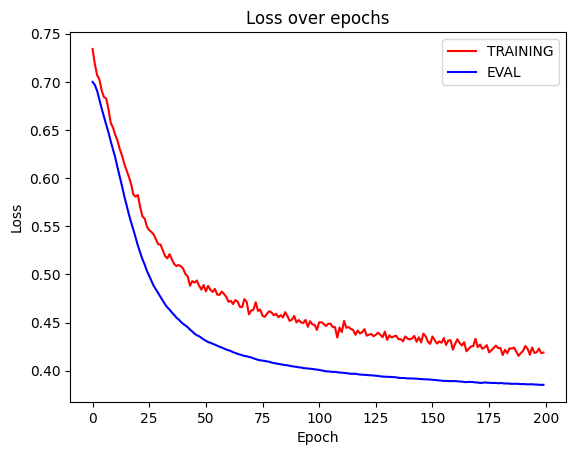

In [50]:
plt.plot(loss_train_values, label='TRAINING', color='red')
plt.plot(loss_val_values, label='EVAL', color='blue')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()



In [51]:
# Define a prediction threshold (e.g., 0.5 for a binary classification threshold)
threshold = 0.5

# Make predictions on the test data
model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))

# Apply the threshold to convert probabilities to binary predictions
test_predictions = (test_outputs >= threshold).float()
    
print(classification_report(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy on Test Data: {accuracy * 100:.2f}%')

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       897
           1       0.80      0.82      0.81       833

    accuracy                           0.81      1730
   macro avg       0.81      0.81      0.81      1730
weighted avg       0.81      0.81      0.81      1730

[[721 176]
 [149 684]]
Accuracy on Test Data: 81.21%


## TEST SET PREDICTION

In [52]:
def prepare_test_set(df):
    
    df = remove_unneccessary_cols(df, ['Name'])
    df = make_age_categorical(df)
    df = standardize_num_columns(df, num_columns)
    df = impute_numeric_cols(df, num_columns)
    df = map_vip_and_cryosleep(df)
    df = split_cabin(df)
    df = one_hot_encode_columns(df, ['HomePlanet', 'Destination', 'AgeGroup', 'deck'])
    df = map_side_column(df)    
    df = categorize_num_column(df)    
    
    df['VIP'].fillna(0, inplace=True)
    df.replace({True:1., False:0.}, inplace=True)
    
    df = fill_most_freq(df, columns_with_nan)
    df['num_label'] = df['num_label'].astype(float)
     
    return df

In [53]:
test_df = prepare_test_set(test_df)

Columns removed: ['Name']


In [54]:
# test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
y_pred_test = model(torch.tensor(test_df.drop('PassengerId', axis=1).values, dtype=torch.float32))

In [55]:
y_pred_test = (y_pred_test >= 0.5).numpy().astype(int) 
y_pred_test = [arr[0] if arr.size == 1 else arr for arr in y_pred_test]
res_df = pd.DataFrame(y_pred_test, index=None, columns= ['Transported'])
res_df = pd.concat([test_df['PassengerId'], res_df['Transported']], axis = 1)

mapping = {0: False, 1: True}
res_df.replace(mapping, inplace=True)
res_df.head()


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [56]:
res_df.to_csv('submission.csv', index=False)